In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_11\Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
# using MatrixCalculus
using JLD2

In [3]:
#Acrobot Dynamics
a = RobotZoo.Acrobot()
h = 0.05

0.05

In [4]:
function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [5]:
function dfdx(x,u)
    ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    ForwardDiff.derivative(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [6]:
function dAdx(x,u)
    ForwardDiff.jacobian(dx->vec(dfdx(dx,u)),x)
end

function dBdx(x,u)
    ForwardDiff.jacobian(dx->dfdu(dx,u),x)
end

function dAdu(x,u)
    ForwardDiff.derivative(du->vec(dfdx(x,du)),u)
end

function dBdu(x,u)
    ForwardDiff.derivative(du->dfdu(x,du),u)
end

dBdu (generic function with 1 method)

In [7]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [8]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.01;
Qn = Array(100.0*I(Nx));

In [9]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*R*u*u
end

stage_cost (generic function with 1 method)

In [10]:
function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

terminal_cost (generic function with 1 method)

In [11]:
function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[k])
    end
    J += terminal_cost(xtraj[:,Nt])
    return J
end

cost (generic function with 1 method)

In [12]:
function backward_pass!(p,P,d,K)
    
    ΔJ = 0.0
    p[:,Nt] .= Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] .= Qn
    
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[k]
    
        A = dfdx(xtraj[:,k], utraj[k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
        
        #Ax = dAdx(xtraj[:,k], utraj[k])
        #Bx = dBdx(xtraj[:,k], utraj[k])
        #Au = dAdu(xtraj[:,k], utraj[k])
        #Bu = dBdu(xtraj[:,k], utraj[k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        #iLQR (Gauss-Newton) version
        Gxx = Q + A'*P[:,:,k+1]*A
        Guu = R + B'*P[:,:,k+1]*B
        Gxu = A'*P[:,:,k+1]*B
        Gux = B'*P[:,:,k+1]*A
        
        #DDP (full Newton) version
        #Gxx = Q + A'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Ax
        #Guu = R + B'*P[:,:,k+1]*B + (kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bu)[1]
        #Gxu = A'*P[:,:,k+1]*B + kron(p[:,k+1]',I(Nx))*comm(Nx,Nx)*Au
        #Gux = B'*P[:,:,k+1]*A + kron(p[:,k+1]',I(Nu))*comm(Nx,Nu)*Bx
        
        β = 0.1
        while !isposdef(Symmetric([Gxx Gxu; Gux Guu]))
            Gxx += A'*β*I*A
            Guu += B'*β*I*B
            Gxu += A'*β*I*B
            Gux += B'*β*I*A
            β = 2*β
            #display("regularizing G")
            #display(β)
        end
        
        d[k] = Guu\gu
        K[:,:,k] .= Guu\Gux
    
        p[:,k] .= dropdims(gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[k] - Gxu*d[k], dims=2)
        P[:,:,k] .= Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[k]
    end
    
    return ΔJ
end

backward_pass! (generic function with 1 method)

In [13]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);
#f = jldopen("guess.jld2", "r")
#utraj = f["utraj"];

In [14]:
#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

1492.5564094475226

In [15]:
#DDP Algorithm
p = ones(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 1.0

xn = zeros(Nx,Nt)
un = zeros(Nt-1)

gx = zeros(Nx)
gu = 0.0
Gxx = zeros(Nx,Nx)
Guu = 0.0
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
while maximum(abs.(d[:])) >  1e-3
    iter += 1    
    
    #Backward Pass
    ΔJ = backward_pass!(p,P,d,K)

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0

    for k = 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
    end
    Jn = cost(xn,un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
        end
        Jn = cost(xn,un)
    end
    
    J = Jn
    xtraj .= xn
    utraj .= un
    
    #display(iter)
    #display(α)
    #display(maximum(abs.(d[:])))
end

In [16]:
iter

330

In [17]:
J

562.1228878150326

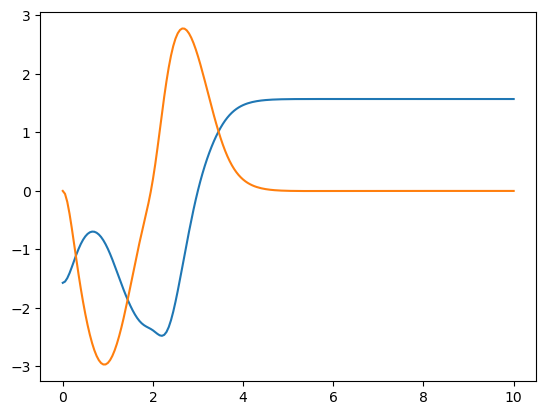

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000076847280>

In [18]:
plot(thist,xtraj[1,:])
plot(thist,xtraj[2,:])

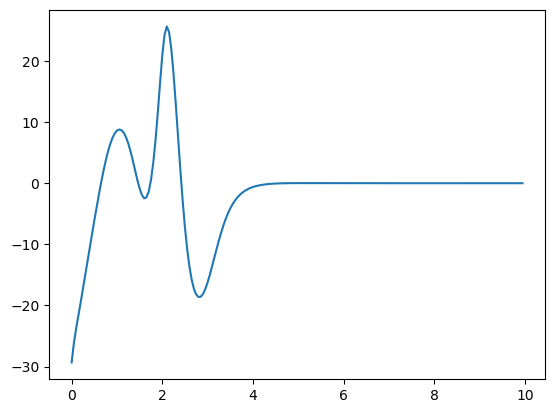

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001A37010>

In [19]:
plot(thist[1:Nt-1],utraj)

In [20]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

[ Info: Precompiling TrajOptPlots [7770976a-8dee-4930-bf39-a1782fd21ce6]
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8702))

In [21]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8702

In [22]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)